# Mon premier réseau

Dans cette ce cours, nous allons construire notre premier réseau de neurones à partir de la library [micrograd](https://github.com/karpathy/micrograd/tree/master) qui est une library permettant le calcul automatique des gradients. Il est conseillé de comprendre les éléments de la library à partir de la traduction proposée dans le dossier MicrogradFR ou de la [vidéo d'introduction](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy) de Andrej Karpathy (en anglais).   
Ce notebook s'inspire également du notebook présent dans le repository de micrograd. 

## Construction d'un réseau avec micrograd

In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

Pour construire un réseau de neurones, nous avons d'abord besoin d'un problème. Pour cela, nous utilisons la fonction [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) de scikit-learn qui permet de créer un dataset.  
Notons qu'il est nécessaire de faire un changement de varible pour faciliter le calcul du loss des parties suivantes. Au lieu d'avoir la classe 0 et la classe 1, nous aurons la classe -1 et la classe 1. 


### Initialisation du dataset

Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


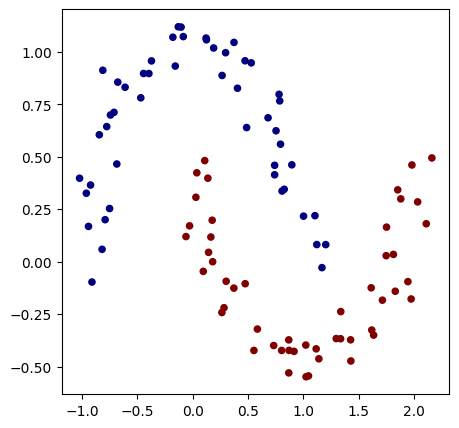

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Création du réseau de neurones

Maintenant, on va initialiser notre réseau de neurones. Notre réseau prend 2 valeurs en entrée et doit nous ressortir un label -1 ou 1.  
Le réseau de neurones que l'on va construire contient 2 couches cachées de 16 neurones chacune.  
Voici un aperçu de l'architecture de ce réseau :  
<img src="images/Mlp.png" alt="Neurone artificiel" width="300"/>

In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### Descente de gradient stochastique (SGD)

Avant de passer à la suite de notre code, il est nécessaire de faire un point sur la descente de gradient stochastique.  
Pour appliquer l'algorithme de descente de gradient sur un dataset de taille $N$, il faudrait en théorie calculer la perte sur chacun des éléments avant de calculer le gradient et de mettre à jour les poids. Cette méthode a l'avantage de garantir une diminution de la perte à chaque itération de l'entraînement mais est très couteuse pour des datasets où $N$ est grand. En pratique, on a souvent $N>10⁶$. De plus, il faudrait garder les valeurs des gradients de l'ensemble des $N$ éléments en mémoire ce qui est impossible pour des ensembles de données trop important.    
Pour palier à ce problème, nous utilisons des mini-batch qui correspondent à des groupes d'échantillons du dataset. L'optimisation se fait de la même manière que sur la descente de gradient sauf que la mise à jour des poids se fait à chaque mini-batch. Le processus d'optimisation est alors beaucoup plus rapide et permet de traiter des grandes quantités de données. A titre indicatif, le paramètre définissant la taille d'un mini-batch est appelé "batch_size" et sa valeur est souvent 16, 32 ou 64.  
Pour en apprendre plus sur la descente du gradient stochastique : [wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) ou [blogpost](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)  

Définissons, en python, une fonction pour récuperer batch_size éléments aléatoires de notre dataset. 

In [4]:
def get_batch(batch_size=64):
  ri = np.random.permutation(X.shape[0])[:batch_size]
  Xb, labels = X[ri], y[ri]
  #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
  # Conversion des inputs en Value pour pouvoir utiliser micrograd
  inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
  return inputs,labels

### Fonction de perte

Pour entraîner notre réseau de neurones, il faut définir une fonction de perte (loss). On a deux classes, on va essayer de maximiser la marge entre les exemples de classes différentes. A l'inverse de la perte de log-vraisemblance négative utilisée précedemment, on va chercher à maximiser l'écart entre les deux classes ce qui va rendre notre méthode robuste aux nouveaux éléments.  
Le loss max-margin est défini comme :  
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
  # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
  losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
  # On divise le loss par le nombre d'éléments du mini-batch
  data_loss = sum(losses) * (1.0 / len(losses))
  return data_loss

### Entraînement du modèle 

Maintenant que l'on posséde les éléments clés de l'entrainement, il est temps de définir notre boucle d'entraînement 

In [6]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=64
iteration=50

In [7]:
for k in range(iteration):
    
  # On récupère notre mini-batch random
  inputs,labels=get_batch(batch_size=batch_size)

  # On fait appel au modèle pour calculer les scores Y
  scores = list(map(model, inputs))
  
  # On calcule le loss
  loss=loss_function(scores,labels)


  accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
  accuracy=sum(accuracy) / len(accuracy)
  
  # Remise à zéro de valeurs de gradients avant de les calculer
  model.zero_grad() 
  # Calcul des gradients grâce à l'autograd de micrograd
  loss.backward() 
  
  # Mise à jour des poids avec les gradients calculés (SGD)
  learning_rate = 1.0 - 0.9*k/100
  for p in model.parameters():
      p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
      print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8784825557712251, accuracy 50.0%
step 1 loss 1.0498636789609819, accuracy 81.25%
step 2 loss 0.3550529988007771, accuracy 87.5%
step 3 loss 0.3817907172288854, accuracy 84.375%
step 4 loss 0.6318706090466502, accuracy 76.5625%
step 5 loss 0.6308304853422904, accuracy 71.875%
step 6 loss 0.7380222102886377, accuracy 79.6875%
step 7 loss 0.39334495918901, accuracy 84.375%
step 8 loss 0.2515744361404421, accuracy 90.625%
step 9 loss 0.30034526807720274, accuracy 87.5%
step 10 loss 0.22291894955606736, accuracy 87.5%
step 11 loss 0.24544659405423325, accuracy 89.0625%
step 12 loss 0.26007903519526376, accuracy 89.0625%
step 13 loss 0.2517736455855373, accuracy 90.625%
step 14 loss 0.29062553909120004, accuracy 89.0625%
step 15 loss 0.29264541526825716, accuracy 85.9375%
step 16 loss 0.28097033781271324, accuracy 89.0625%
step 17 loss 0.20530110759425793, accuracy 90.625%
step 18 loss 0.15414153816909906, accuracy 93.75%
step 19 loss 0.2025418592611501, accuracy 92.1875%
step 

(-1.548639298268643, 1.951360701731357)

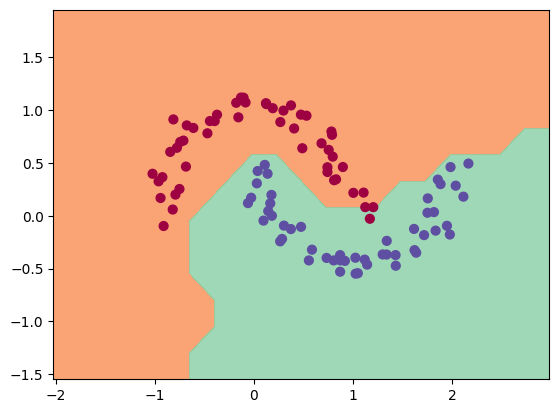

In [8]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())